# Formula learning

A toy example to learn a formula to predict a synthetic data


Let's say we have a regression problem to predict a target value in $\cal{R}$. 
Input data has $M$ features and a target is computed as 
$$
y_{i} = f(\mathbf x)
$$
we will try various functions $f$ to observe ability to learn it using a DNN.

## A warm-up

Let us predict a simple function : $f(\mathbf x) = 1 + \sum_{i} x_i$

In [1]:
import os

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


n_samples = 10000
n_features = 10
x_max = 100.0
x_min = -100.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [2]:
def f(x):
    return np.sum(x) + 1.0

In [3]:
trainval_y = np.zeros((n_samples, 1))
for i, x in enumerate(trainval_x):
    trainval_y[i, 0] = f(x)

In [4]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [5]:
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,-58.163334,2.876890,-89.843547,13.597636,-26.572044,-52.152477,32.912810,-98.227805,-84.341799,-83.654835,-442.568507
1,-14.444697,16.258739,-55.944373,-30.150949,58.148185,1.005720,-38.929898,-42.154122,59.409346,94.864833,49.062784
2,-22.632742,-57.130203,-71.475608,-83.588566,-27.231327,64.170899,3.824039,58.297450,13.786903,-96.159502,-217.138657
3,73.279976,-18.655504,-99.174172,99.073132,-78.238612,-38.438064,14.263687,-4.132039,3.927273,17.312803,-29.781519
4,-94.038643,-66.885168,84.498374,8.657750,-62.904910,-30.106228,-2.755148,-32.958401,97.845367,71.467683,-26.179324


In [6]:
df.loc[0, ['x_%i' % i for i in range(10)]].sum() + 1.0, df.loc[1, ['x_%i' % i for i in range(10)]].sum() + 1.0 

(-442.56850674722648, 49.062784316773119)

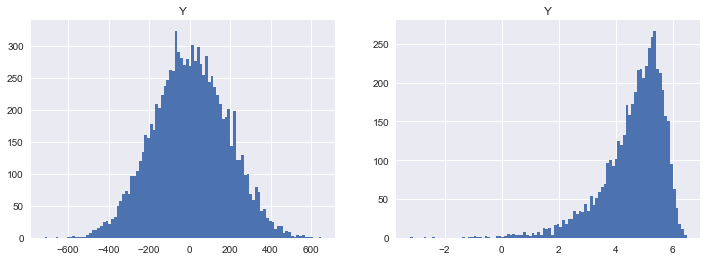

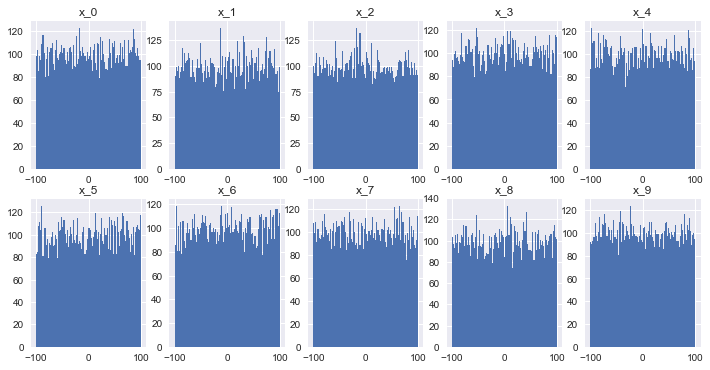

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=100)
plt.title('Y')
plt.subplot(122)
df['y'].apply(np.log).hist(bins=100)
plt.title('Y')

plt.figure(figsize=(12, 6))
for i in range(n_features):
    plt.subplot(2, n_features/2, i+1)
    df['x_%i' % i].hist(bins=100)
    plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = b_i + \langle W_i, \mathbf x \rangle,
$$

In [8]:
import tensorflow as tf

In [18]:
def nn(x):    
    b = tf.Variable(tf.random_uniform((1,)), name='b')
    W = tf.Variable(tf.random_uniform((x.get_shape().as_list()[1], 1)), name='W') 
    return tf.add(b, tf.matmul(x, W))

In [19]:
def np_loss(y_true, y_pred):
    return np.mean(np.mean(np.power(y_true - y_pred, 2.0), axis=-1))

def tf_loss(Y_true, Y_pred):
    return tf.reduce_mean(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1))

def tf_rmse(Y_true, Y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1)))

In [20]:
y_true = np.ones((100, 1))
y_pred = np.linspace(-2, 2, num=100).reshape((100, 1))

lss = np_loss(y_true, y_pred)

with tf.Session() as sess:    
    Y_true = tf.placeholder(tf.float32, shape=(None, 1))
    Y_pred = tf.placeholder(tf.float32, shape=(None, 1))
    lss2, rmse = sess.run([tf_loss(Y_true, Y_pred), tf_rmse(Y_true, Y_pred)], feed_dict={Y_true: y_true, Y_pred: y_pred})

print("Loss numpy :", lss)
print("Loss tf :", lss2)
print("RMSE :", rmse)
    

Loss numpy : 2.36026936027
Loss tf : 2.36027
RMSE : 1.25758


In [21]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))
Y_true = tf.placeholder(tf.float32, shape=(None, 1))

In [22]:
train_params = {    
    'lr_kwargs': {
        'boundaries': [150, 250, 350],
        'values': [0.0001, 0.00005, 0.000001]
    },
    'lr_f': tf.train.piecewise_constant,        
    'training_epochs': 600,
    'batch_size': 512,
    
    # Tensorboard
    'logs_path': 'logs'
}

In [23]:
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Model    
    Y_pred = nn(X)
    
with tf.name_scope('Loss'):
    # Minimize error using MAE
    loss = tf_loss(Y_true, Y_pred)
    
with tf.name_scope('Optimizer'):
    # Gradient Descent
    global_step = tf.Variable(0, trainable=False)    
    lr_f = train_params['lr_f'](global_step, **train_params['lr_kwargs'])    
    optimizer = tf.train.GradientDescentOptimizer(lr_f).minimize(loss)
    
with tf.name_scope('RMSE'):    
    rmse = tf_rmse(Y_true, Y_pred)

# Create a summary to monitor loss tensor
tf.summary.scalar("loss", loss)
# Create a summary to monitor RMSE tensor
tf.summary.scalar("RMSE", rmse)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

In [35]:
from sklearn.model_selection import train_test_split

verbose = 1
display_step = 100

# Launch the graph
print("Start training")
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(train_params['logs_path'], graph=sess.graph)

    
    batch_size = train_params['batch_size']        
    train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, train_size=0.75)
    
    n_train_batchs = int(train_x.shape[0]/batch_size)
    n_val_batchs = int(val_x.shape[0]/batch_size)    
    
    # Training cycle
    for epoch in range(train_params['training_epochs']):
               
        if verbose > 0 and (epoch+1) % display_step == 0:
            print("Epoch: %04d" % (epoch+1))
        
        avg_loss = 0.0
        avg_rmse = 0.0
        # Train over all batches            
        for i in range(n_train_batchs):

            if verbose > 1:
                print("-- %i / %i" % (i, n_train_batchs))

            
            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = train_x[i_start:i_end,:], train_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            _, l, r, y_pred, summary = sess.run([optimizer, loss, rmse, Y_pred, merged_summary_op],
                                                feed_dict={X: batch_xs, Y_true: batch_ys})
            
            if verbose > 2:
                print("Numpy Loss: %f" % np_loss(batch_ys, y_pred))
                print("TF Loss: %f" % l)
                print("TF RMSE: %f" % r)
                
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * n_train_batchs + i)
            
            # Compute average loss
            avg_loss += l * 1.0 / n_train_batchs
            avg_rmse += r * 1.0 / n_train_batchs            
            
        # Display logs per epoch step
        if verbose > 0 and (epoch+1) % display_step == 0:
            print("loss=%.9f, rmse=%.9f" % (avg_loss, avg_rmse))
        
        # Validation
        avg_loss = 0.0
        avg_rmse = 0.0        
        for i in range(n_val_batchs):
            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = val_x[i_start:i_end,:], val_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            run_options = None
            run_metadata = None
            if i % 100 == 99:
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
            
            l, r, summary = sess.run([loss, rmse, merged_summary_op], 
                                     feed_dict={X: batch_xs, Y_true: batch_ys}, 
                                     run_metadata=run_metadata, options=run_options)
            # Compute average loss
            avg_loss += l / n_val_batchs
            avg_rmse += r / n_val_batchs            
            
        # Display logs per epoch step
        if verbose > 0 and (epoch+1) % display_step == 0:
            print("val_loss=%.9f, val_rmse=%.9f" % (avg_loss, avg_rmse))

    print("Optimization Finished!")
    
    B = sess.graph.get_tensor_by_name('Model/b:0')
    Weights = sess.graph.get_tensor_by_name('Model/W:0')
    b, weights = sess.run([B, Weights])

Start training
Epoch: 0100
loss=0.000100420, rmse=0.009985913
val_loss=0.000100997, val_rmse=0.009984126
Epoch: 0200
loss=0.000057353, rmse=0.007546598
val_loss=0.000057724, val_rmse=0.007547798
Epoch: 0300
loss=0.000032776, rmse=0.005704956
val_loss=0.000032970, val_rmse=0.005704305
Epoch: 0400
loss=0.000018696, rmse=0.004308668
val_loss=0.000018806, val_rmse=0.004308622
Epoch: 0500
loss=0.000010709, rmse=0.003260815
val_loss=0.000010770, val_rmse=0.003260247
Epoch: 0600
loss=0.000006118, rmse=0.002464837
val_loss=0.000006150, val_rmse=0.002463641
Optimization Finished!


In [36]:
b

array([ 0.99753976], dtype=float32)

In [37]:
weights

array([[ 1.00000381],
       [ 1.00000167],
       [ 1.00000012],
       [ 0.99999899],
       [ 0.99999905],
       [ 1.00000155],
       [ 0.99999893],
       [ 1.00000107],
       [ 0.99999928],
       [ 1.00000012]], dtype=float32)

## A ratio-like and squared formula

Let $M=10$ and the function to learn is defined as 
$$
f(\mathbf x) = \frac{\sum_i a_i x_i + b} {\sum_i c_i x_i + d} + \alpha \sum_{i,j \neq i} x_i x_j + \beta
$$
where coefficients $a_i$, $b$, $c_i$, $d$, $\alpha$, $\beta$ are randomly chosen.

Setup input data :

In [38]:
import os
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

n_samples = 10000
n_features = 10
a = np.random.rand(n_features)
b = 1.0
c = np.random.rand(n_features)
d = np.random.rand() * 100.0
alpha = np.random.rand() * 1.0 / 50.0
beta = np.random.rand() * 50.0

x_max = 100.0
x_min = -50.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [39]:
def f(sample_x):
    numerator = np.dot(a, sample_x) + b
    denominator = np.dot(c, sample_x) + d
    t1 = numerator / denominator
    
    t2 = 0
    for v in sample_x:
        t2 += v * (np.sum(sample_x) - v)    
    t2 *= alpha
    return t1 + t2 + beta

In [40]:
trainval_y = np.zeros((n_samples, 1))
for i, x in enumerate(trainval_x):
    trainval_y[i] = f(x)

In [41]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [42]:
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,11.513303,36.769926,-3.870751,-38.994689,91.861252,53.203344,13.077445,-11.462807,38.448680,-38.650759,94.907720
1,82.538553,98.811235,49.281148,43.695110,36.574020,17.054123,-23.198698,20.270047,-33.915752,40.219298,1366.736816
2,66.661198,46.549012,96.472850,72.245619,7.420768,16.922571,-26.628587,-5.941434,-28.247721,89.813495,1330.988646
3,93.149732,67.251168,-3.588349,35.297837,96.399783,-41.895572,42.871415,69.088980,97.687309,76.921817,3864.721315
4,-42.088323,-24.991506,1.797192,77.362365,-32.680734,-28.926408,24.535549,-20.161910,46.975193,70.306120,-210.178316


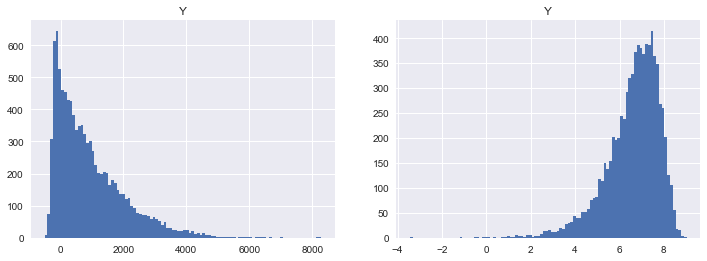

In [43]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=100)
plt.title('Y')
plt.subplot(122)
df['y'].apply(np.log).hist(bins=100)
plt.title('Y')

# plt.figure(figsize=(12, 6))
# for i in range(n_features):
#     plt.subplot(2, n_features/2, i+1)
#     df['x_%i' % i].hist(bins=100)
#     plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = \prod_{i=0}^{l-1} \left( b_i + \langle W_i, g(\mathbf x) \rangle \right),
$$
where 
$$
g(\mathbf x) = g_m(\mathbf x) = h^{(1)}_{m,m-1}(\mathbf x) + \frac{1}{\epsilon + h^{(2)}_{m,m-1}(\mathbf x)}
$$
and 
$$
h^{(i)}_{m,m-1}(\mathbf x) = \text{activation}(\langle W_{i,m}, g_{m-1}(\mathbf x) \rangle + b_{i,m}), \\
g_{0} (\mathbf x) = \mathbf x
$$


In [44]:
import tensorflow as tf

In [76]:
def tf_rmse(Y_true, Y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1)))

def tf_loss(Y_true, Y_pred):
    l1 = tf.reduce_mean(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1))
    l2 = tf.log(1.0 + tf_rmse(Y_true, Y_pred))
    return tf.minimum(l1, l2)

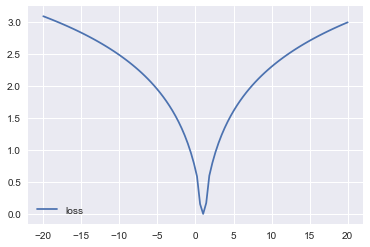

In [77]:
with tf.Session() as sess:
    n = 100
    Y_true = tf.placeholder(tf.float32, shape=(None, 1))
    Y_pred = tf.placeholder(tf.float32, shape=(None, 1))
    loss = np.zeros((n,))
    yspan = np.linspace(-20, 20, num=n)
    for i, v in enumerate(yspan):
        y_true = np.ones((1, 1))
        y_pred = np.array(v).reshape((1, 1))
        loss[i] = sess.run(tf_loss(Y_true, Y_pred), feed_dict={Y_true: y_true, Y_pred: y_pred})

plt.figure()
plt.plot(yspan, loss, label='loss')
plt.legend()


In [122]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))
Y_true = tf.placeholder(tf.float32, shape=(None, 1))

train_params = {    
    
#     'lr_kwargs': {
#         'boundaries': [50, 100, 200, 500, 1000, ],
#         'values': [1e-3, 1e-4, 5*1e-5, 0.000001, 0.0000001]
#     },
#     'lr_f': tf.train.piecewise_constant,        
    
    'lr_kwargs': {
        'decay_steps': 100,
        'decay_rate': 0.9,
        'learning_rate': 0.005,
        'staircase': True
    },
    'lr_f': lambda x, **kwargs: tf.train.exponential_decay(global_step=x, **kwargs),
    
    'training_epochs': 5000,
    'batch_size': 1024,
    
    'seed': 2017,
    
    # Tensorboard
    'logs_path': 'logs'
}

In [123]:
epsilon = tf.constant(1e-10)

def h(index, m, x, n_filters, with_activation=True):    
    b = tf.Variable(tf.random_uniform([n_filters]), 
                    name='bias_%i_%i' % (index, m))
    W = tf.Variable(tf.random_uniform(shape=[x.get_shape().as_list()[1], n_filters]), 
                    name="W_%i_%i" % (index, m))
    
    name = name='h_%i_%i' % (index, m)
    out = tf.add(tf.matmul(x, W), b)
    if with_activation:
        return tf.nn.elu(out, name=name)
    else:
        return tf.identity(out, name=name)
    
    
def g(m, x, n_filters_list):        
    _x = x if m == 0 else g(m-1, x, n_filters_list)
    inv_h2 = tf.divide(tf.constant(1.0), tf.add(epsilon, h(2, m, _x, n_filters_list[m])))
    return tf.add(h(1, m, _x, n_filters_list[m]), inv_h2, name='g_%i' % m)


def nn(x, k, m):    
    nf = 5
    n_filters_list = [nf for j in range(m)]       
    net = h(3, 0, g(m-1, x, n_filters_list), n_filters=1, with_activation=False)
    for i in range(1, k):
        n_filters_list = [nf for j in range(m)]               
        net = tf.multiply(net, h(3, 0, g(m-1, x, n_filters_list), n_filters=1, with_activation=False))
    return net
    

In [124]:
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Model
    Y_pred = nn(X, k=2, m=3)
    
with tf.name_scope('Loss'):
    # Minimize error using MAE
    loss = tf_loss(Y_true, Y_pred)
    
with tf.name_scope('Optimizer'):
    # Gradient Descent
    global_step = tf.Variable(0, trainable=False)    
    lr_f = train_params['lr_f'](global_step, **train_params['lr_kwargs'])    
    optimizer = tf.train.GradientDescentOptimizer(lr_f).minimize(loss)
    
with tf.name_scope('RMSE'):
    # Accuracy    
    rmse = tf_rmse(Y_true, Y_pred)

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("RMSE", rmse)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

In [127]:
from datetime import datetime
from sklearn.model_selection import train_test_split

verbose = 1
display_step = 10

# Launch the graph
tf.set_random_seed(train_params['seed'])
print("Start training")
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(os.path.join(train_params['logs_path'], 
                                                        'run_%s' % str(datetime.now().strftime("%Y-%m-%d-%H-%M"))), 
                                           graph=sess.graph)

    
    batch_size = train_params['batch_size']        
    train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, train_size=0.75)
    
    n_train_batchs = int(train_x.shape[0]/batch_size)
    n_val_batchs = int(val_x.shape[0]/batch_size)    
    
    # Training cycle
    for epoch in range(train_params['training_epochs']):
               
        if verbose > 0 and (epoch+1) % display_step == 0:
            print("Epoch: %04d" % (epoch+1))
        
        avg_loss = 0.0
        avg_rmse = 0.0
        # Train over all batches
        lr = sess.run(lr_f, feed_dict={global_step: epoch})
        for i in range(n_train_batchs):

            if verbose > 1:
                print("-- %i / %i" % (i, n_train_batchs))

            
            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = train_x[i_start:i_end,:], train_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            run_options = None
            run_metadata = None
            if i % 100 == 99:
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
            _, l, r, y_pred, summary = sess.run([optimizer, loss, rmse, Y_pred, merged_summary_op],
                                                feed_dict={X: batch_xs, Y_true: batch_ys}, 
                                                run_metadata=run_metadata, options=run_options)
            
            if verbose > 2:
                print("Numpy Loss: %f" % np_loss(batch_ys, y_pred))
                print("TF Loss: %f" % l)
                print("TF RMSE: %f" % r)
                
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * n_train_batchs + i)
            
            # Compute average loss
            avg_loss += l * 1.0 / n_train_batchs
            avg_rmse += r * 1.0 / n_train_batchs            
            
        # Display logs per epoch step
        if verbose > 0 and (epoch+1) % display_step == 0:
            print("loss=%.9f, rmse=%.9f | lr=%f" % (avg_loss, avg_rmse, lr))
        
        # Validation
        avg_loss = 0.0
        avg_rmse = 0.0        
        for i in range(n_val_batchs):
            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = val_x[i_start:i_end,:], val_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            run_options = None
            run_metadata = None
            if i % 100 == 99:
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
            
            l, r, summary = sess.run([loss, rmse, merged_summary_op], 
                                     feed_dict={X: batch_xs, Y_true: batch_ys}, 
                                     run_metadata=run_metadata, options=run_options)
            # Compute average loss
            avg_loss += l / n_val_batchs
            avg_rmse += r / n_val_batchs            
            
        # Display logs per epoch step
        if verbose > 0 and (epoch+1) % display_step == 0:
            print("val_loss=%.9f, val_rmse=%.9f" % (avg_loss, avg_rmse))

    print("Optimization Finished!")


Start training
Epoch: 0010
loss=14.844446046, rmse=2801230.035714285 | lr=0.005000
val_loss=14.734274387, val_rmse=2506194.000000000
Epoch: 0020
loss=12.136494092, rmse=509812.040597098 | lr=0.005000
val_loss=14.172854900, val_rmse=1429530.000000000
Epoch: 0030
loss=11.968138967, rmse=183292.291852679 | lr=0.005000
val_loss=9.633372784, val_rmse=15264.949707031
Epoch: 0040
loss=13.164558956, rmse=522764.352678571 | lr=0.005000
val_loss=13.009580612, val_rmse=446672.125000000
Epoch: 0050
loss=10.737809590, rmse=55753.293247768 | lr=0.005000
val_loss=10.371188641, val_rmse=31925.432617188
Epoch: 0060
loss=11.970908301, rmse=158565.484375000 | lr=0.005000
val_loss=11.795203686, val_rmse=132614.210937500
Epoch: 0070
loss=6.496970654, rmse=723.643646240 | lr=0.005000
val_loss=7.263734341, val_rmse=1426.585083008
Epoch: 0080
loss=6.451427460, rmse=656.184295654 | lr=0.005000
val_loss=6.458249092, val_rmse=636.943908691
Epoch: 0090
loss=6.706156594, rmse=840.295676095 | lr=0.005000
val_loss=6

KeyboardInterrupt: 